In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#database connection settings
import psycopg2

db_name = "traviato_development"
db_host = "localhost"
db_port = "5432"
db_user = "lievgarcia"
db_pwd = "traviato81"

conn = psycopg2.connect(database=db_name, user=db_user, password=db_pwd, host=db_host, port=db_port)

In [3]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 
         'date_start', 'date_end', 'premiere_date', 'performance_count', 'composer_country', 'theatre_category']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       c.country as composer_country, " + \
        "       CASE WHEN l.source_id = 1 then 'Professional' when opera_america_name IS NULL THEN 'Amateur' ELSE 'Professional' END as theatre_category " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN theatre_mapping tm ON l.theatre = tm.name " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE w.uri != 'W1' " + \
        "ORDER BY s.id DESC, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)


In [9]:
######################## libraries ########################

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np

import sys
sys.path.append('../../')

from utils.utility_functions import label_top
from utils.utility_functions import get_last_name
from utils.utility_functions import make_dash_zero

##################### CHARTING OPTIONS #####################

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})

rc('text', usetex=True)
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']


##################### SOURCES OPTIONS #####################

archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper', 
                    'Chicago Lyric Opera','San Francisco Opera','Czech National Theatre','Glyndebourne','Salzburg Festival',
                    'Sweden Opera House','National Opera de Paris','Opera Comique']
commercial_sources_world = ['bachtrack.com','operabase.com','operacritic.com']
commercial_sources_uk = ['Concert-Diary','U.K. Theatre Web']
government_sources = ['National Central Opera Service Reports', 'Opera America']

##############################################################################

In [124]:
######################## Archive Sources  ########################
######################## CDF per source ########################

a_df = mdf.copy()
a_df = a_df[a_df['source_name'].isin(archival_sources)]
a_df = a_df.groupby(['composer'])
a_df = a_df.agg({'performance_count': np.sum })
a_df = a_df.reset_index(level=['composer'])
a_df = a_df.sort_values(by=['performance_count'], ascending=False)
a_df = a_df.reset_index() 
a_df = a_df.drop(columns=['index'])
a_df.index += 1
a_df = c_df.reset_index()
a_df = c_df.rename({'index': 'Ranking'}, axis='columns')
a_df.head()
data_archives = a_df['performance_count'].values

######################## WORLD           ########################

w_df = mdf.copy()
w_df = w_df[w_df['source_name'].isin(commercial_sources_world)]
w_df = w_df[w_df['year'] > 2007]
w_df = w_df[['composer', 'work', 'country', 'state', 'city', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'year', 'decade', 'work_decade', 'composer_country']]
w_df = w_df.drop_duplicates()

w_df = w_df.groupby(['composer'])
w_df = w_df.agg({'performance_count': np.sum })
w_df = w_df.reset_index(level=['composer'])
w_df = w_df.sort_values(by=['performance_count'], ascending=False)
w_df = w_df.reset_index() 
w_df = w_df.drop(columns=['index'])
w_df.index += 1
w_df = w_df.reset_index()
w_df = w_df.rename({'index': 'Ranking'}, axis='columns')
w_df.head()
data_world = w_df['performance_count'].values
    
###############################################################

oa_df = mdf.copy()
oa_df = oa_df[oa_df['source_name'] == 'Opera America']
oa_df = oa_df.groupby(['composer'])
oa_df = oa_df.agg({'performance_count': np.sum })
oa_df = oa_df.reset_index(level=['composer'])
oa_df = oa_df.sort_values(by=['performance_count'], ascending=False)
oa_df = oa_df.reset_index() 
oa_df = oa_df.drop(columns=['index'])
oa_df.index += 1
oa_df = oa_df.reset_index()
oa_df = oa_df.rename({'index': 'Ranking'}, axis='columns')
oa_df.head()
data_us = oa_df['performance_count'].values
    
###############################################################

In [127]:
data_archives

array([5559, 3920, 3660, 1875, 1180, 1017,  906,  833,  830,  575,  479,
        359,  321,  312,  312,  296,  287,  287,  256,  241,  237,  233,
        225,  152,  138,  137,  121,  117,  114,  113,   92,   85,   75,
         73,   70,   67,   67,   66,   63,   57,   57,   55,   54,   51,
         49,   43,   41,   40,   39,   39,   35,   33,   32,   29,   26,
         23,   22,   22,   22,   21,   20,   19,   18,   18,   18,   17,
         17,   16,   16,   14,   14,   14,   13,   13,   13,   13,   12,
         12,   12,   11,   11,   10,   10,    9,    9,    8,    8,    8,
          8,    8,    8,    8,    7,    7,    7,    7,    7,    7,    7,
          7,    6,    6,    6,    6,    6,    6,    6,    6,    5,    5,
          5,    5,    4,    4,    4,    4,    4,    4,    3,    3,    3,
          3,    1,    1,    1,    1,    1,    1])

1.48638521742
5.0
0.0459590830959


Calculating best minimal value for power law fit


NameError: name 'savefig' is not defined

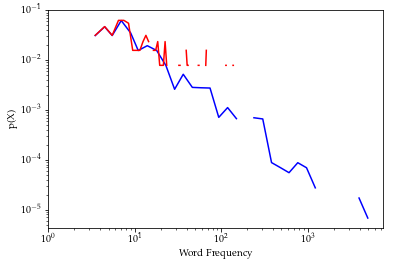

In [122]:
import powerlaw
data = c_df['performance_count'].values
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)
print(results.power_law.sigma)
# R, p = results.distribution_compare('power_law', 'lognormal')
R, p = results.distribution_compare('power_law', 'exponential')


figPDF = powerlaw.plot_pdf(data, color='b')
powerlaw.plot_pdf(data, linear_bins=True, color='r', ax=figPDF)
####
figPDF.set_ylabel("p(X)")
figPDF.set_xlabel(r"Word Frequency")
figname = 'FigPDF'
savefig(figname+'.eps', bbox_inches='tight')
#savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

plt.show


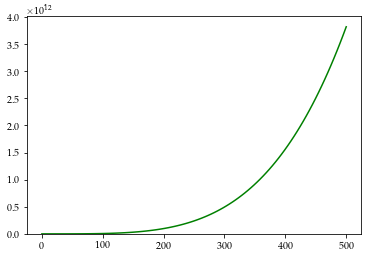

In [96]:
a = 5. # shape
samples = 500
s = np.random.power(a, samples)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, bins=30)
x = np.linspace(0, 500, 100)
y = a*x**(a-1.)
normed_y = samples*np.diff(bins)[0]*y
plt.plot(x, normed_y)
plt.show()

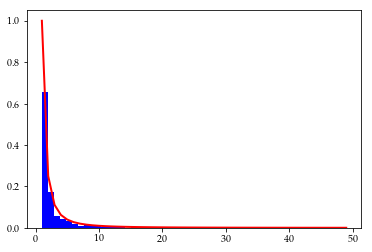

In [7]:
import matplotlib.pyplot as plt
from scipy import special

a = 2. # parameter
s = np.random.zipf(a, 1000)

count, bins, ignored = plt.hist(s[s<50], 50, normed=True)
x = np.arange(1., 50.)
y = x**(-a) / special.zetac(a)
plt.plot(x, y/max(y), linewidth=2, color='r')
plt.show()

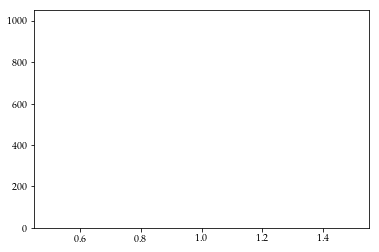

In [112]:
import matplotlib.pyplot as plt
from scipy import special

a = 2. # parameter
s = np.random.zipf(a, 1000)
s = c_df['performance_count'].values


count, bins, ignored = plt.hist(s[s<50], 50, normed=True)
x = np.arange(1., 50.)
# y = x**(-a) / special.zetac(a)
# plt.plot(x, y/max(y), linewidth=2, color='r')
plt.show()

In [109]:
c_df

,source_id,source_name,composer,work,country,state,city,theatre,date_start,date_end,premiere_date,performance_count,composer_country,theatre_category,year,decade,work_decade
473798,2,Metropolitan Opera,Georges Bizet,Carmen,United States,New York,New York,Metropolitan Opera,2004-10-16,2004-10-16,1875.0,1,France,Professional,2004,2000,1870
473799,2,Metropolitan Opera,Georges Bizet,Carmen,United States,New York,New York,Metropolitan Opera,1998-11-05,1998-11-05,1875.0,1,France,Professional,1998,1990,1870
473800,2,Metropolitan Opera,Giacomo Puccini,Madama Butterfly,United States,New York,New York,Metropolitan Opera,1974-06-22,1974-06-22,1904.0,1,Italy,Professional,1974,1970,1900
473801,2,Metropolitan Opera,Giuseppe Verdi,Macbeth,United States,New York,New York,Metropolitan Opera,1973-06-04,1973-06-04,1847.0,1,Italy,Professional,1973,1970,1840
473802,2,Metropolitan Opera,Giuseppe Verdi,Un ballo in maschera,United States,New York,New York,Metropolitan Opera,1973-01-23,1973-01-23,1859.0,1,Italy,Professional,1973,1970,1850
473803,2,Metropolitan Opera,Giuseppe Verdi,Aida,United States,New York,New York,Metropolitan Opera,1972-10-14,1972-10-14,1871.0,1,Italy,Professional,1972,1970,1870
473804,2,Metropolitan Opera,Wolfgang Amadeus Mozart,Don Giovanni,United States,New York,New York,Metropolitan Opera,1972-10-13,1972-10-13,1787.0,1,Austria,Professional,1972,1970,1780
473805,2,Metropolitan Opera,Giuseppe Verdi,Ernani,United States,New York,New York,Metropolitan Opera,1971-01-16,1971-01-16,1844.0,1,Italy,Professional,1971,1970,1840
473806,2,Metropolitan Opera,Umberto Giordano,Andrea Chénier,United States,New York,New York,Metropolitan Opera,1971-01-14,1971-01-14,1896.0,1,Italy,Professional,1971,1970,1890
473807,2,Metropolitan Opera,Giuseppe Verdi,Aida,United States,New York,New York,Metropolitan Opera,1968-02-02,1968-02-02,1871.0,1,Italy,Professional,1968,1960,1870


In [107]:
# counter_of_counts